## 2. Predict the session length for a given IP

In [1]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql.window import Window
from pyspark.sql.functions import lag, to_timestamp, col, when, sum, avg, count, split, explode, udf, collect_list, monotonically_increasing_id, row_number, size
from pyspark import Row
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.types import ArrayType, TimestampType
import datetime
from matplotlib import pyplot as plt

In [2]:
from pyspark.ml.feature import VectorAssembler, OneHotEncoder, StringIndexer
from pyspark.ml.regression import RandomForestRegressor, LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

In [3]:
sc = SparkContext.getOrCreate()

In [4]:
spark = SparkSession.builder.getOrCreate()

In [5]:
df = spark.read \
       .format("csv") \
       .option("header", "true") \
       .option("inferSchema", "true") \
       .load("data/sessions/*.csv")

In [6]:
df.limit(10).toPandas()

,user_id,user_session_id,minutes
0,113.193.98.244,0,19
1,115.250.76.126,0,16
2,103.250.155.27,0,16
3,110.227.71.215,0,16
4,119.81.61.166,3,20
5,122.165.107.203,0,16
6,120.138.116.67,1,32
7,180.215.235.1,0,17
8,192.193.116.143,0,16
9,43.251.172.133,0,17


In [7]:
df.dtypes

[('user_id', 'string'), ('user_session_id', 'int'), ('minutes', 'int')]

In [8]:
df = df.withColumnRenamed('minutes', 'label')
df.show()

+---------------+---------------+-----+
|        user_id|user_session_id|label|
+---------------+---------------+-----+
| 113.193.98.244|              0|   19|
| 115.250.76.126|              0|   16|
| 103.250.155.27|              0|   16|
| 110.227.71.215|              0|   16|
|  119.81.61.166|              3|   20|
|122.165.107.203|              0|   16|
| 120.138.116.67|              1|   32|
|  180.215.235.1|              0|   17|
|192.193.116.143|              0|   16|
| 43.251.172.133|              0|   17|
|  46.236.26.103|              0|   16|
| 117.211.82.178|              0|   30|
| 117.221.134.55|              0|   16|
| 182.69.222.108|              0|   16|
|  70.39.187.252|              0|   18|
|     1.38.23.15|              0|   16|
|106.216.145.218|              0|   17|
| 106.51.241.129|              0|   17|
|   122.161.6.87|              0|   16|
|     1.23.14.99|              0|   16|
+---------------+---------------+-----+
only showing top 20 rows



In [9]:
df = df.withColumn('ip', split(col('user_id'), '\.'))
df.show()

+---------------+---------------+-----+--------------------+
|        user_id|user_session_id|label|                  ip|
+---------------+---------------+-----+--------------------+
| 113.193.98.244|              0|   19| [113, 193, 98, 244]|
| 115.250.76.126|              0|   16| [115, 250, 76, 126]|
| 103.250.155.27|              0|   16| [103, 250, 155, 27]|
| 110.227.71.215|              0|   16| [110, 227, 71, 215]|
|  119.81.61.166|              3|   20|  [119, 81, 61, 166]|
|122.165.107.203|              0|   16|[122, 165, 107, 203]|
| 120.138.116.67|              1|   32| [120, 138, 116, 67]|
|  180.215.235.1|              0|   17|  [180, 215, 235, 1]|
|192.193.116.143|              0|   16|[192, 193, 116, 143]|
| 43.251.172.133|              0|   17| [43, 251, 172, 133]|
|  46.236.26.103|              0|   16|  [46, 236, 26, 103]|
| 117.211.82.178|              0|   30| [117, 211, 82, 178]|
| 117.221.134.55|              0|   16| [117, 221, 134, 55]|
| 182.69.222.108|       

In [10]:
df.dtypes

[('user_id', 'string'),
 ('user_session_id', 'int'),
 ('label', 'int'),
 ('ip', 'array<string>')]

In [11]:
df = df.select(df.ip[0].alias('ip_0'), df.ip[1].alias('ip_1'), df.ip[2].alias('ip_2'), df.ip[3].alias('ip_3'), 'label')

In [12]:
features = [f for f in df.schema.names if f != 'label']
features

['ip_0', 'ip_1', 'ip_2', 'ip_3']

In [13]:
for feature in features:
    indexer = StringIndexer(inputCol=feature, outputCol=feature + '_ix')
    df = indexer.fit(df).transform(df)
df.show()

+----+----+----+----+-----+-------+-------+-------+-------+
|ip_0|ip_1|ip_2|ip_3|label|ip_0_ix|ip_1_ix|ip_2_ix|ip_3_ix|
+----+----+----+----+-----+-------+-------+-------+-------+
| 113| 193|  98| 244|   19|   33.0|   37.0|  153.0|  224.0|
| 115| 250|  76| 126|   16|    7.0|   25.0|  143.0|   69.0|
| 103| 250| 155|  27|   16|    6.0|   25.0|  120.0|   84.0|
| 110| 227|  71| 215|   16|   45.0|   39.0|   49.0|  207.0|
| 119|  81|  61| 166|   20|   35.0|  245.0|   23.0|   48.0|
| 122| 165| 107| 203|   16|    2.0|  178.0|    0.0|  144.0|
| 120| 138| 116|  67|   32|   20.0|  198.0|  127.0|   56.0|
| 180| 215| 235|   1|   17|   21.0|    8.0|  194.0|   25.0|
| 192| 193| 116| 143|   16|   47.0|   37.0|  127.0|  146.0|
|  43| 251| 172| 133|   17|   27.0|   56.0|   86.0|   81.0|
|  46| 236|  26| 103|   16|   72.0|   99.0|  164.0|   75.0|
| 117| 211|  82| 178|   30|    0.0|   86.0|   44.0|   11.0|
| 117| 221| 134|  55|   16|    0.0|   29.0|   34.0|  122.0|
| 182|  69| 222| 108|   16|    5.0|   87

In [14]:
features = [f + '_ix' for f in features]
features

['ip_0_ix', 'ip_1_ix', 'ip_2_ix', 'ip_3_ix']

In [15]:
ohe_features = [f + '_ohe' for f in features]
ohe_features

['ip_0_ix_ohe', 'ip_1_ix_ohe', 'ip_2_ix_ohe', 'ip_3_ix_ohe']

In [16]:
ohe = OneHotEncoder(inputCols=features, outputCols=ohe_features)
transformer = ohe.fit(df)

In [17]:
df = transformer.transform(df)

In [18]:
df.show()

+----+----+----+----+-----+-------+-------+-------+-------+----------------+-----------------+-----------------+-----------------+
|ip_0|ip_1|ip_2|ip_3|label|ip_0_ix|ip_1_ix|ip_2_ix|ip_3_ix|     ip_0_ix_ohe|      ip_1_ix_ohe|      ip_2_ix_ohe|      ip_3_ix_ohe|
+----+----+----+----+-----+-------+-------+-------+-------+----------------+-----------------+-----------------+-----------------+
| 113| 193|  98| 244|   19|   33.0|   37.0|  153.0|  224.0|(191,[33],[1.0])| (255,[37],[1.0])|(255,[153],[1.0])|(255,[224],[1.0])|
| 115| 250|  76| 126|   16|    7.0|   25.0|  143.0|   69.0| (191,[7],[1.0])| (255,[25],[1.0])|(255,[143],[1.0])| (255,[69],[1.0])|
| 103| 250| 155|  27|   16|    6.0|   25.0|  120.0|   84.0| (191,[6],[1.0])| (255,[25],[1.0])|(255,[120],[1.0])| (255,[84],[1.0])|
| 110| 227|  71| 215|   16|   45.0|   39.0|   49.0|  207.0|(191,[45],[1.0])| (255,[39],[1.0])| (255,[49],[1.0])|(255,[207],[1.0])|
| 119|  81|  61| 166|   20|   35.0|  245.0|   23.0|   48.0|(191,[35],[1.0])|(255,[2

In [19]:
va = VectorAssembler(inputCols=ohe_features, outputCol='features')
df = va.transform(df)

In [20]:
df.show()

+----+----+----+----+-----+-------+-------+-------+-------+----------------+-----------------+-----------------+-----------------+--------------------+
|ip_0|ip_1|ip_2|ip_3|label|ip_0_ix|ip_1_ix|ip_2_ix|ip_3_ix|     ip_0_ix_ohe|      ip_1_ix_ohe|      ip_2_ix_ohe|      ip_3_ix_ohe|            features|
+----+----+----+----+-----+-------+-------+-------+-------+----------------+-----------------+-----------------+-----------------+--------------------+
| 113| 193|  98| 244|   19|   33.0|   37.0|  153.0|  224.0|(191,[33],[1.0])| (255,[37],[1.0])|(255,[153],[1.0])|(255,[224],[1.0])|(956,[33,228,599,...|
| 115| 250|  76| 126|   16|    7.0|   25.0|  143.0|   69.0| (191,[7],[1.0])| (255,[25],[1.0])|(255,[143],[1.0])| (255,[69],[1.0])|(956,[7,216,589,7...|
| 103| 250| 155|  27|   16|    6.0|   25.0|  120.0|   84.0| (191,[6],[1.0])| (255,[25],[1.0])|(255,[120],[1.0])| (255,[84],[1.0])|(956,[6,216,566,7...|
| 110| 227|  71| 215|   16|   45.0|   39.0|   49.0|  207.0|(191,[45],[1.0])| (255,[39],[

In [21]:
df.count()

110835

In [22]:
df.dtypes

[('ip_0', 'string'),
 ('ip_1', 'string'),
 ('ip_2', 'string'),
 ('ip_3', 'string'),
 ('label', 'int'),
 ('ip_0_ix', 'double'),
 ('ip_1_ix', 'double'),
 ('ip_2_ix', 'double'),
 ('ip_3_ix', 'double'),
 ('ip_0_ix_ohe', 'vector'),
 ('ip_1_ix_ohe', 'vector'),
 ('ip_2_ix_ohe', 'vector'),
 ('ip_3_ix_ohe', 'vector'),
 ('features', 'vector')]

In [23]:
train, test = df.randomSplit([0.7, 0.3], seed=2020)
train.count(), test.count()

(77582, 33253)

In [24]:
algorithm = LinearRegression(featuresCol="features")

model = algorithm.fit(train)               

predictions = model.transform(test)

evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")    

rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 4.44103


In [25]:
results = predictions.select('label', 'prediction').sample(withReplacement=True, fraction=0.001, seed=2020).toPandas()
results

,label,prediction
0,16,17.505572
1,16,18.156796
2,32,18.138554
3,16,17.183748
4,16,18.073892
5,20,17.173687
6,17,19.297432
7,18,19.484934
8,16,19.010394
9,16,16.073646


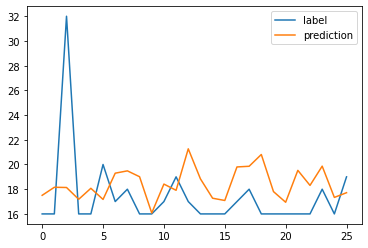

In [26]:
plt.plot(results.index, results.label)
plt.plot(results.index, results.prediction)
plt.legend(['label', 'prediction'])
plt.show()

In [27]:
spark.stop()